In [124]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [125]:
PATH = "./Data/FER2013"

trainDir = os.path.join(PATH, 'train')
testDir = os.path.join(PATH, 'test')
valDir = os.path.join(PATH, "validation")

In [126]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # MobileNetV2 requires these dims

In [251]:
trainingDataSet = tf.keras.utils.image_dataset_from_directory(trainDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
testingDataSet = tf.keras.utils.image_dataset_from_directory(testDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valDataSet = tf.keras.utils.image_dataset_from_directory(valDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 3141 files belonging to 7 classes.


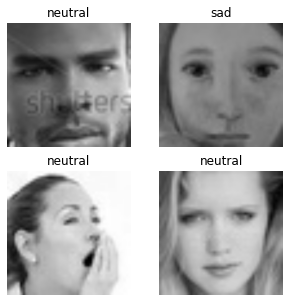

In [253]:
classNames = trainingDataSet.class_names

plt.figure(figsize=(5,5))
for images, labels in trainingDataSet.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i+ 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")


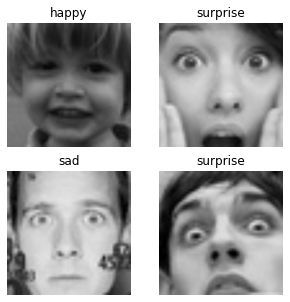

In [256]:
plt.figure(figsize=(5,5))
for images, labels in valDataSet.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i+ 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

In [257]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label


# valDataSet = valDataSet.map(process)

In [258]:
#Buffered prefetching to help performance
# autotune = tf.data.AUTOTUNE

# trainingDataSet = trainingDataSet.prefetch(buffer_size=autotune)
# testingDataSet = testingDataSet.prefetch(buffer_size=autotune)
# valDataSet = valDataSet.prefetch(buffer_size=autotune)

In [259]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [260]:
#Download pre-trained model
baseModel = tf.keras.applications.MobileNetV2()

In [261]:
#convert image to blocks of features
image_batch, label_batch = next(iter(trainingDataSet))
feature_batch = baseModel(image_batch)
print(feature_batch.shape)

(32, 1000)


In [262]:
# baseModel.trainable = False

In [263]:

base_input = baseModel.layers[0].input  
base_output = baseModel.layers[-2].output

final_output = preprocess_input(base_output) #Normalize the inputs
final_output = layers.Dense(128)(base_output) #add new layer after output of global pooling layer
final_output = layers.Activation('relu')(final_output) #activation function
final_output = layers.Dropout(0.2)(final_output)     #****
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('sigmoid')(final_output)
final_output = layers.Dropout(0.2)(final_output) 
final_output = layers.Dense(7, activation='softmax')(final_output) #classification layer


model = keras.Model(inputs =  base_input, outputs = final_output)



In [264]:
base_learning_rate = 0.000001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [265]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [266]:
len(model.trainable_variables)

162

In [267]:
# #Initial loss/Accuracy
# loss0, accuracy0 = model.evaluate(valDataSet)

In [268]:

model0 = model.fit(trainingDataSet, epochs=11, validation_data=valDataSet)

#Run0: training[loss: 0.4509 - accuracy: 0.8379 - No dropout, learning rate = adam]  testing[loss: 1.7335 - accuracy: 0.5867]
#Run1: training[loss: 0.1826 - accuracy: 0.9399 - dropout(0.1) after activations, learning rate = adam]  testing[loss: loss: 2.0663 - accuracy: 0.5737]

Epoch 1/11
898/898 [==============================] - 447s 492ms/step - loss: 1.3260 - accuracy: 0.5042 - val_loss: 2.3804 - val_accuracy: 0.2623
Epoch 2/11
898/898 [==============================] - 402s 445ms/step - loss: 1.1578 - accuracy: 0.5747 - val_loss: 2.9828 - val_accuracy: 0.1468
Epoch 3/11
898/898 [==============================] - 366s 405ms/step - loss: 1.0918 - accuracy: 0.5963 - val_loss: 2.1653 - val_accuracy: 0.3999
Epoch 4/11
898/898 [==============================] - 367s 407ms/step - loss: 1.0343 - accuracy: 0.6211 - val_loss: 2.1095 - val_accuracy: 0.4002
Epoch 5/11
898/898 [==============================] - 383s 424ms/step - loss: 0.9798 - accuracy: 0.6394 - val_loss: 1.8829 - val_accuracy: 0.3645
Epoch 6/11
898/898 [==============================] - 375s 415ms/step - loss: 0.9407 - accuracy: 0.6594 - val_loss: 1.9867 - val_accuracy: 0.4202
Epoch 7/11
898/898 [==============================] - 388s 430ms/step - loss: 0.8945 - accuracy: 0.6757 - val_loss: 1.6293 -

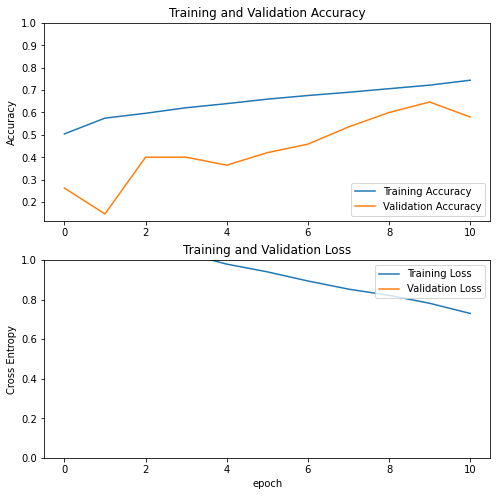

In [269]:
acc = model0.history['accuracy']
val_acc = model0.history['val_accuracy']

loss = model0.history['loss']
val_loss = model0.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [270]:
model.evaluate(testingDataSet)

225/225 [==============================] - 33s 76ms/step - loss: 1.6093 - accuracy: 0.4948


[1.6093484163284302, 0.49484536051750183]

Fine Tuning

In [271]:
model.trainable = True

In [272]:
len(model.layers)

162

In [273]:
fineTune = 50

for layer in model.layers[:fineTune]:
    layer.trainable = False

In [274]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [275]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [276]:
history1 = model.fit(trainingDataSet, epochs=22, initial_epoch=model0.epoch[-1], validation_data=valDataSet)

Epoch 11/22
898/898 [==============================] - 163s 175ms/step - loss: 0.6954 - accuracy: 0.7568 - val_loss: 0.8215 - val_accuracy: 0.7259
Epoch 12/22
898/898 [==============================] - 159s 174ms/step - loss: 0.6339 - accuracy: 0.7822 - val_loss: 0.6918 - val_accuracy: 0.7625
Epoch 13/22
898/898 [==============================] - 158s 174ms/step - loss: 0.5842 - accuracy: 0.7997 - val_loss: 0.6523 - val_accuracy: 0.7720
Epoch 14/22
898/898 [==============================] - 159s 175ms/step - loss: 0.5457 - accuracy: 0.8154 - val_loss: 0.6637 - val_accuracy: 0.7752
Epoch 15/22
898/898 [==============================] - 159s 175ms/step - loss: 0.4980 - accuracy: 0.8343 - val_loss: 0.7093 - val_accuracy: 0.7606
Epoch 16/22
898/898 [==============================] - 159s 175ms/step - loss: 0.4662 - accuracy: 0.8456 - val_loss: 0.6671 - val_accuracy: 0.7892
Epoch 17/22
898/898 [==============================] - 159s 175ms/step - loss: 0.4337 - accuracy: 0.8594 - val_loss: 0

In [277]:
model.evaluate(testingDataSet)

225/225 [==============================] - 36s 90ms/step - loss: 1.8175 - accuracy: 0.5676


[1.8174769878387451, 0.5675675868988037]

In [278]:
fineTune = 100

for layer in model.layers[:fineTune]:
    layer.trainable = False

In [279]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [281]:
history1 = model.fit(trainingDataSet, epochs=29, initial_epoch=history1.epoch[-1], validation_data=valDataSet)

Epoch 22/29
898/898 [==============================] - 137s 150ms/step - loss: 0.2048 - accuracy: 0.9406 - val_loss: 0.3013 - val_accuracy: 0.9153
Epoch 23/29
898/898 [==============================] - 135s 147ms/step - loss: 0.1860 - accuracy: 0.9471 - val_loss: 0.2149 - val_accuracy: 0.9373
Epoch 24/29
898/898 [==============================] - 132s 145ms/step - loss: 0.1676 - accuracy: 0.9518 - val_loss: 0.3562 - val_accuracy: 0.8943
Epoch 25/29
898/898 [==============================] - 138s 152ms/step - loss: 0.1494 - accuracy: 0.9584 - val_loss: 0.2764 - val_accuracy: 0.9220
Epoch 26/29
898/898 [==============================] - 135s 149ms/step - loss: 0.1421 - accuracy: 0.9613 - val_loss: 0.2294 - val_accuracy: 0.9319
Epoch 27/29
898/898 [==============================] - 133s 146ms/step - loss: 0.1388 - accuracy: 0.9632 - val_loss: 0.2563 - val_accuracy: 0.9239
Epoch 28/29
898/898 [==============================] - 134s 147ms/step - loss: 0.1466 - accuracy: 0.9599 - val_loss: 0

In [282]:
model.evaluate(testingDataSet)

225/225 [==============================] - 35s 86ms/step - loss: 2.0319 - accuracy: 0.6056


[2.031883478164673, 0.6056004166603088]

In [ ]:
model.save("Model/V0")